### CT Statewide House Sales Transactions
This notebook is exploring the data from https://data.ct.gov/Housing-and-Development/Real-Estate-Sales-2001-2016/5mzw-sjtu?category=Housing-and-Development , which lists CT statewide sales transactions on individual properties from 2001-2016.
* Note: this link includs a PDF that explains each of the NonUseCodes.

My GitHub repository: https://github.com/jamiekasulis/ct_real_estate_sales, where you can view
* The raw data file
* The notebook I used to clean that file
* The clean data files that I analyze here

### Potential Inquiries
* See where properties with multiple transactions gained and lost value --> (How many houses, how much value, by town, over different periods of time)
* Foreclosures-- where and when have there been a lot?
* Building of new developments? (Might be shown by selling many houses in a short period of time on a new road)
* Signs of house flipping, i.e. a purchase and a sale for significantly more within a short period
* Has recovery been different for different segments of the market (different price-range houses)?
* Are there observable effects of the crumbling fundations in the northeastern part of CT?

### Calculations
* Adjust sales prices for inflation/season -- there is a Python package for seasonal adjustment
* Take a close look at the assessment column
* Each town's assessment rate, or look at a hosue's sale ratio relative to its town only
* Distribution of house prices in given towns, or on given streets
* Town-by-town medians, ranges

### Themes
* Recovery

In [ ]:
import pandas as pd
import matplotlib
%matplotlib inline

#### Update MAX_YEAR when new data comes out.

In [ ]:
MIN_YEAR = 2001
MAX_YEAR = 2016 # update this when new data comes out

In [3]:
def combine_data_into_master_df():
    """
    Returns a DataFrame which combines all of the clean CSVs for each year.
    """
    # Combine the year-by-year clean csvs, which are located at 'data/clean_data_20xx_listings.csv'
    df = pd.read_csv('data/clean_data_' + str(MIN_YEAR) + '_listings.csv')
    for year in range(MIN_YEAR+1, MAX_YEAR+1):
        df = df.append(pd.read_csv('data/clean_data_' + str(year) + '_listings.csv'))

    # Now remove the index column
    #df = df.drop('Unnamed: 0', 1)
    return df

In [4]:
df = combine_data_into_master_df()
df.head()

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks
0,684,10173,2001,04/17/2002 12:00:00 AM,Ansonia,1-3 EAGLE STREET,63630,116000.0,54.853448,Residential,Two Family,0,NaN
1,694,10005,2001,10/04/2001 12:00:00 AM,Ansonia,1 CRESTWOOD ROAD,76370,160000.0,47.731250,Residential,Single Family,0,NaN
2,697,10253,2001,06/18/2002 12:00:00 AM,Ansonia,1 DAVIES CT,97720,180000.0,54.288889,Residential,Single Family,0,NaN
3,698,10094,2001,01/17/2002 12:00:00 AM,Ansonia,1 DOREL TER,110600,259900.0,42.554829,Residential,Single Family,0,NaN
4,710,10100,2001,01/30/2002 12:00:00 AM,Ansonia,1 JAMES STREET,63210,132000.0,47.886364,Residential,Single Family,0,NaN


In [ ]:
df.tail()

In [ ]:
# Make sure the IDs match the right rows from the original raw file
df.sort_values('ID') # Looks good

### Notes on the data frames
* Use DataFrame 'df' if you want to look at ALL of the data
* Use 'use_df' if you want to just look at the rows that don't have NonUseCodes. You should use use_df if you are calculating any statistics.
* Use 'res_df' if you want to look at RESIDENTIAL properties (but not condos or apartments) that don't have NonUseCodes. Best way to observe the real estate market in general.

In [5]:
def get_residential(df):
    """
    Returns just the residential properties.
    """
    return df[df['PropertyType'] == 'Residential']

def get_commercial(df):
    """
    Returns just the commercial properties.
    """
    return df[df['PropertyType'] == 'Commercial']

In [6]:
use_df = df[df['NonUseCode'] < 1]
res_df = get_residential(use_df)

In [7]:
# Check
use_df[use_df['NonUseCode'] != -1]
res_df[res_df['PropertyType'] != 'Residential']

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks


### Foreclosures-- where and when have there been a lot?
Note: In order for this analysis to be truthfully valuable, you should do some kind of adjustment. This might be very complicated. (Adjusting by population fails to weigh folks living in apartments, for example.)

In [ ]:
# How many foreclosures on properties 2001-2016?
foreclosures = df[df['NonUseCode'] == 14]
print("Number of properties that have been foreclosed on: %d" %len(foreclosures['Address'].unique()))

#### Make a function to return a DataFrame that ranks towns by most foreclosures.

In [ ]:
def count_foreclosures_by_town(df, town, years=(MIN_YEAR, MAX_YEAR), property_type = 'Residential'):
    """
    Returns a subset of df of foreclosed properties from town.
    Is a helper function for make_foreclosures_by_town_dict()
    """
    # Make sure proper arguments passed
    if property_type not in ['Residential', 'Commercial', 'All']:
        raise Exception("Not a valid property_type.")
        return
    if years[0] < MIN_YEAR or years[1] > MAX_YEAR:
        raise Exception("Not a valid year range")
        return
    
    else:
        # Convert year range to a list of all years in that range
        years = list(range(years[0], years[1]+1))
    
    subset = df[(df['Town'] == town) & (df['ListYear'].isin(years)) & (df['NonUseCode'] == 14)]
    return subset

In [ ]:
def make_foreclosures_by_town_dict(df, years=(MIN_YEAR, MAX_YEAR), property_type = 'Residential'):
    """
    Returns a dictionary with keys = town name and value = number of foreclosures.
    This function feeds make_rankings_df_from_dict.
    """
    foreclosure_ranks_by_town = {}
    for town in df['Town'].unique():
        if town not in foreclosure_ranks_by_town.keys():
            foreclosure_ranks_by_town[town] = len(count_foreclosures_by_town(df, town, years, property_type))
    return foreclosure_ranks_by_town

In [ ]:
def make_rankings_df_from_dict(dictionary, value_name):
    """
    Makes a dataframe out of a dictionary. First column name is 'Town' and second is value_name.
    dictionary should be produced by an explicit call to make_foreclosures_by_town_dict.
    """
    df = pd.DataFrame.from_dict(data=dictionary, orient='index') # make initial df
    df['Town'] = df.index # pull index out into its own column
    df.columns = [value_name, 'Town'] # Set column names
    df = df[['Town', value_name]] # Reorder the columns
    
    df = df.sort_values(value_name, ascending=False, ) # Sort
    df = df.reset_index(drop=True)
    
    return df

In [ ]:
def rank_towns_by_foreclosure_count(df, years=(MIN_YEAR, MAX_YEAR), property_type = 'Residential'):
    """
    Returns a dataframe of each town and the number of foreclosures they experienced in the range 'years'.
    Descending order. Index+1 can serve as the rank.
    The only function you should have to explicitly call to do this. All helper functions are called within.
    """
    return make_rankings_df_from_dict(make_foreclosures_by_town_dict(df), 'Foreclosures')

In [ ]:
# Dataframe of foreclosure rankings by town, all years (MIN_YEAR to MAX_YEAR)
fc_rankings_town_all_years = rank_towns_by_foreclosure_count(df)

In [ ]:
fc_rankings_town_all_years.head()

### Calculate town-by-town statistics
* Median assessed value
* Median sale amount
* Median sales ratio

### Dataframes:
* town_df for all residential properties without NonUseCodes in time range MINYEAR - MAXYEAR

In [8]:
# Make a dataframe with each town. We will store summary statistics in this dataframe.
town_df = pd.DataFrame(columns=['Town', 'MedianAssessedValue', 'MedianSaleAmount', 'MedianSalesRatio',
                               'MinAssessedValue', 'MaxAssessedValue', 'MinSaleAmount', 'MaxSaleAmount',
                               'MinSalesRatio', 'MaxSalesRatio'])
town_df['Town'] = df['Town'].unique()

In [ ]:
town_df.head(10)

In [9]:
def calculate_median_for_town(source_df, town, column, residential=True):
    """
    Calculates the median value of 'column' for a given town from df.
    NOTE: This is the median assessed value for SOLD properties. Will be
    different from the median assessed value for ALL properties.
    
    source_df should omit properties with a NonUseCode.
    """
    just_this_town = source_df[source_df['Town'] == town]
    
    if residential==True:
        just_this_town = get_residential(just_this_town)
    
    return just_this_town[column].median()

In [10]:
def calculate_medians_for_all_towns(town_df_arg, source_df, column, residential=True):
    """
    Calculates the median value of 'column' for ALL unique towns in df.
    Returns this information as a DataFrame
    """
    median_column_name = 'Median' + column
    new_town_df = town_df_arg.copy()
    for index in new_town_df.index:
        town = new_town_df.loc[index, 'Town']
        new_town_df.loc[index, median_column_name] = calculate_median_for_town(source_df, town, column, residential)
    
    return new_town_df

In [11]:
town_df = calculate_medians_for_all_towns(town_df, res_df, 'AssessedValue')

In [ ]:
town_df.head(10)

In [12]:
town_df = calculate_medians_for_all_towns(town_df, res_df, 'SaleAmount')
town_df = calculate_medians_for_all_towns(town_df, res_df, 'SalesRatio')

In [ ]:
town_df.head(10)

In [ ]:
# Let's check to make sure the numbers match.
berlin_sales = res_df[(res_df['Town'] == 'Berlin') & (res_df['PropertyType'] == 'Residential')]
print(berlin_sales['AssessedValue'].median())
print(berlin_sales['SaleAmount'].median())
print(berlin_sales['SalesRatio'].median())

In [ ]:
avon_sales = res_df[(res_df['Town'] == 'Avon') & (res_df['PropertyType'] == 'Residential')]
print(avon_sales['AssessedValue'].median())
print(avon_sales['SaleAmount'].median())
print(avon_sales['SalesRatio'].median())

### Calculate SalesRatio
If my calculation of it is the same, then they use their SaleAmount to calculate it. Otherwise, they are using a market estimation.

*Data page defines SalesRatio as 'Ratio of the sale price to the assessed value.' I want to know if 'sales price' refers to SalesAmount or not.*

In [ ]:
res_df[['Address', 'AssessedValue', 'SaleAmount', 'SalesRatio']].head(5)

I'll calculate SalesRatio myself and compare them side-by-side.

In [ ]:
res_df_testing = res_df.copy()
res_df_testing['MySalesRatio'] = res_df_testing['AssessedValue'] / res_df_testing['SaleAmount']
res_df_testing[['SalesRatio', 'MySalesRatio']].head()

For some reason, the first row has a SalesRatio of 0 when it doesn't seem like it should be. Could be an error when the data was entered.

### Calculate minimum and maximum sale amounts for each town

In [13]:
def get_town_min(source_df, town_df, town, column):
    """
    Finds the row with the minimum value of column for a given town in source_df.
    Saves this to town_df (as a separate copy).
    
    source_df should be residential properties w/o NonUseCodes if you are using res_df.
    """
    just_this_town = source_df[source_df['Town'] == town] # get the data for just this town
    
    min_val = just_this_town[column] # a list of values to find the minimum from
    min_val = min_val.min() # Grab the minimum column value
    min_row = just_this_town[just_this_town[column] == min_val] # Grab the row
    return min_row

In [ ]:
get_town_min(res_df, town_df, 'Berlin', 'SaleAmount')

In [14]:
def get_town_max(source_df, town_df, town, column):
    """
    Finds the row with the maximum value of column for a given town in source_df.
    Saves this to town_df (as a separate copy).
    
    source_df should be residential properties w/o NonUseCodes if you are using res_df.
    """
    just_this_town = source_df[source_df['Town'] == town] # get the data for just this town
    
    town_df = just_this_town[column] # a list of values to find the minimum from
    max_val = town_df.max() # Grab the minimum column value
    max_row = just_this_town[just_this_town[column] == max_val] # Grab the row
    return max_row

In [ ]:
get_town_max(res_df, town_df, 'Berlin', 'SaleAmount')

In [15]:
def calculate_town_mins_and_maxes(source_df, town_df, column):
    """
    Will use the data from source_df to calculate mins and maxes for column for every town.
    """
    new_town_df = town_df.copy()
    
    # Calculate min and max for each town
    for index in town_df.index:
        max_val = get_town_max(source_df, town_df, town_df.loc[index, 'Town'], column)[column].iloc[0]
        min_val = get_town_min(source_df, town_df, town_df.loc[index, 'Town'], column)[column].iloc[0]
    
        # Add to new_town_df
        min_column_name = 'Min' + column
        max_column_name = 'Max' + column
        new_town_df.loc[index, min_column_name] = min_val
        new_town_df.loc[index, max_column_name] = max_val
    
    return new_town_df

In [16]:
town_df = calculate_town_mins_and_maxes(res_df, town_df, 'SaleAmount')
town_df = calculate_town_mins_and_maxes(res_df, town_df, 'SalesRatio')
town_df = calculate_town_mins_and_maxes(res_df, town_df, 'AssessedValue')
town_df.head(5)

,Town,MedianAssessedValue,MedianSaleAmount,MedianSalesRatio,MinAssessedValue,MaxAssessedValue,MinSaleAmount,MaxSaleAmount,MinSalesRatio,MaxSalesRatio
0,Ansonia,112600,207000,1.4554,23600,312600,20100,710000,0.271374,129.145
1,Ashford,121700,199900,0.904245,27640,1094690,40000,4.025e+06,0.256527,124.14
2,Avon,266180,417500,0.791192,3500,2896370,7500,5e+06,0.180948,112.09
3,Barkhamsted,139195,238250,0.896428,22160,440750,15000,700000,0.408118,155.267
4,Berlin,155900,253500,0.759083,0,1571000,4000,1.35608e+06,0,100.88


In [ ]:
get_town_max(res_df, town_df, 'Ansonia', 'SalesRatio')

In [ ]:
get_town_min(res_df, town_df, 'Ansonia', 'SalesRatio')

In [ ]:
get_town_max(res_df, town_df, 'Ansonia', 'AssessedValue')

In [ ]:
get_town_min(res_df, town_df, 'Ansonia', 'AssessedValue')

In [ ]:
ansonia = res_df[res_df['Town'] == 'Ansonia']
ansonia.sort_values('SalesRatio', ascending=True)
ansonia.sort_values('SalesRatio', ascending=False)
ansonia.sort_values('AssessedValue', ascending=True)
ansonia.sort_values('AssessedValue', ascending=False)
# Looks good.

In [18]:
town_df.head(10)

,Town,MedianAssessedValue,MedianSaleAmount,MedianSalesRatio,MinAssessedValue,MaxAssessedValue,MinSaleAmount,MaxSaleAmount,MinSalesRatio,MaxSalesRatio
0,Ansonia,112600,207000,1.4554,23600,312600,20100,710000,0.271374,129.145
1,Ashford,121700,199900,0.904245,27640,1094690,40000,4.025e+06,0.256527,124.14
2,Avon,266180,417500,0.791192,3500,2896370,7500,5e+06,0.180948,112.09
3,Barkhamsted,139195,238250,0.896428,22160,440750,15000,700000,0.408118,155.267
4,Berlin,155900,253500,0.759083,0,1571000,4000,1.35608e+06,0,100.88
5,Bethany,207570,341000,0.868738,17210,678960,12000,1.38e+06,0.304681,137.227
6,Bethel,196480,335000,0.877093,18200,799680,25000,1.4e+06,0.0398337,84.6953
7,Bethlehem,185600,300000,1.17461,46890,722060,33500,1.35e+06,0.212731,157.045
8,Bloomfield,114950,195950,0.830904,0,965020,15000,1.685e+06,0,101.56
9,Bolton,162185,254950,0.81474,49800,522300,65000,770000,0.357488,100


In [ ]:
town_df.sort_values('MedianSaleAmount', ascending=False)

### These medians, mins, and maxes use data from all of the years.
Should I also be able to select just a particular year...?

### Time series
I want to be able to...
* Make the time series for a town's SaleAmount, MIN_YEAR to MAX_YEAR

In [19]:
def get_years_median(column, year, town='Connecticut', source_df=res_df):
    """
    Returns the median value of column for town from year, using data from source_df, as a list.
    """
    
    if town != 'Connecticut':
        # Get the rows for this town in the given year
        just_this_town = source_df[source_df['Town'] == town]
    else:
        # Look at all the data from the state
        just_this_town = source_df

    # Grab just the year you want
    town_by_year = just_this_town[just_this_town['ListYear'] == year]

    # Calculate and return the median
    median = town_by_year[column].median()
    if median == 'nan':
        return -1
    else:
        return median

In [ ]:
get_years_median('SaleAmount', 2006, 'Berlin')

In [20]:
def median_timeseries(column, town='Connecticut', startyear=MIN_YEAR, endyear=MAX_YEAR, source_df=res_df):
    """
    Returns a time series for a particular town and column, from start year to endyear.
    Values are the median of column.
    Grabs the data from source_df.
    """
    # Make the DataFrame's attributes
    index = list(range(startyear, endyear+1))
    columns = [town]
    
    # Generate a list of medians using helper function
    list_of_medians = []
    for year in index:
        list_of_medians.append(get_years_median(column, year, town))
        
    return pd.DataFrame(data=list_of_medians, index=index, columns=columns)

In [ ]:
median_timeseries( 'SaleAmount', 'Berlin')

In [ ]:
median_timeseries('SaleAmount', 'Ansonia')

In [ ]:
res_df[res_df['ListYear'] == 2001]
df[df['ListYear'] == 2001]

In [ ]:
median_timeseries('SaleAmount', 'Ansonia')

In [ ]:
median_timeseries('SaleAmount', 'Hartford')

In [ ]:
median_timeseries('SaleAmount', 'Hartford').plot()

In [ ]:
median_timeseries('SaleAmount', 'Meriden').plot()

In [ ]:
median_timeseries('SaleAmount', 'Milford').plot()

In [ ]:
median_timeseries('SaleAmount') # Connecticut

In [ ]:
median_timeseries('SaleAmount').plot()

<font color='red'>2014 is clearly a significant year.</font>

### Best way to break up towns to look at their SaleAmount trends?
* Metropolitan areas?
* Nonmetropolitan areas?
* __Price levels__

In [ ]:
print('median\t%d' %res_df['SaleAmount'].median())
res_df['SaleAmount'].describe()

In [ ]:
res_df_level_1 = res_df[res_df['SaleAmount'].isin(range(200000, 300000))]
res_df_level_2 = res_df[res_df['SaleAmount'].isin(range(3000000, 4000000))]

In [ ]:
res_df_level_1

In [ ]:
median_timeseries(column='SaleAmount', source_df=res_df_level_1).plot(title='Median Sale Amount of Homes, $200k-300k')

In [ ]:
median_timeseries(column='SaleAmount', source_df=res_df_level_2).plot(title='Median Sale Amount of Homes, $2mil-3mil')

Wait... what insight does this provide...

### Looking at median SaleAmount by town and year

In [ ]:
# Calculate number of homes sold in these price ranges. These are just extremes to get started.
print("200k-300k\t\t2mil - 3mil")
for year in range(MIN_YEAR, MAX_YEAR+1):
    print("%d\t\t%d\t\t%d" 
          %(len(res_df_level_1[res_df_level_1['ListYear'] == year]),
           len(res_df_level_2[res_df_level_2['ListYear'] == year]),
           year)
         )

In [ ]:
ct_number_sold = []
years = list(range(MIN_YEAR, MAX_YEAR+1))
for year in range(MIN_YEAR, MAX_YEAR+1):
    print(len(res_df[res_df['ListYear'] == year]))
    



In [ ]:
ct_number_sold_df = pd.DataFrame(data=ct_number_sold, index=years, columns=['Number of Residentials Sold']), 

In [ ]:
ct_number_sold_df

In [ ]:
greenwich_median_sale_amount_ts = median_timeseries('SaleAmount', 'Greenwich')
greenwich_median_sale_amount_ts.transpose()

In [21]:
def median_timeseries_all_towns(column, startyear=MIN_YEAR, endyear=MAX_YEAR, source_df=res_df):
    """
    Returns a time series of all towns in CT, as well as the CT average.
    Each column is a year with values being the median of 'column' for that town in that year.
    """
    # Make the DataFrame's attributes
    columns = list(range(startyear, endyear+1))
    time_series = pd.DataFrame(columns=columns, data = median_timeseries(column).transpose())
    
    for town in source_df['Town'].unique():
        time_series = pd.concat([time_series, median_timeseries(column, town).transpose()])
            
    return time_series

In [22]:
saleamount_ts_all = median_timeseries_all_towns('SaleAmount')

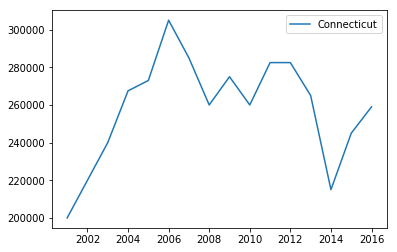

In [23]:
saleamount_ts_all[saleamount_ts_all.index == 'Connecticut'].transpose().plot()
# Median home price decreases 2008-2010, meaning the concentration of homes sold is among more inexpensive homes
# (in the 260,000-280,000 range.)

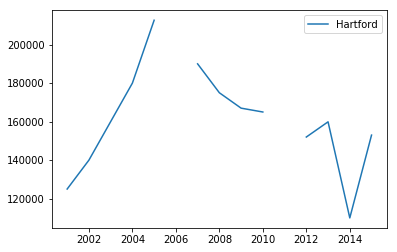

In [24]:
saleamount_ts_all[saleamount_ts_all.index == 'Hartford'].transpose().plot()
# Cheaper homes are being sold in Hartford. Median sale amount from 2007-2013 has gone from 190,000 to 160,000.

### Looking at the number of homes sold in each town each year

In [25]:
def get_years_sale_count(year, town='Connecticut', source_df=res_df):
    """
    Returns the nummber of sales in one town from year, using data from source_df, as a list.
    """
    
    if town != 'Connecticut':
        # Get the rows for this town in the given year
        just_this_town = source_df[source_df['Town'] == town]
    else:
        # Look at all the data from the state
        just_this_town = source_df

    # Grab just the year you want
    town_by_year = just_this_town[just_this_town['ListYear'] == year]

    # Calculate and return the median
    count = len(town_by_year)
    if count == 'nan':
        return -1
    else:
        return count

In [ ]:
print(get_years_sale_count(2015))
print(len(res_df[res_df['ListYear'] == 2015]))

In [26]:
def sale_count_timeseries(town='Connecticut', startyear=MIN_YEAR, endyear=MAX_YEAR, source_df=res_df):
    """
    Returns a time series for a particular town and column, from start year to endyear.
    Values are the number of sales in that town in that year.
    Grabs the data from source_df.
    """
    # Make the DataFrame's attributes
    index = list(range(startyear, endyear+1))
    columns = [town]
    
    # Generate a list of medians using helper function
    list_of_sale_counts = []
    for year in index:
        list_of_sale_counts.append(get_years_sale_count(year, town))
        
    return pd.DataFrame(data=list_of_sale_counts, index=index, columns=columns)

In [ ]:
sale_count_timeseries()

In [ ]:
# So clearly the number of houses sold dropped during the Great Recession and picked back up in 2014, but from before, we
# also know that the pick-up that happened in 2014 was due to sales in more average value homes.
sale_count_timeseries().plot()

In [27]:
def sale_count_timeseries_all_towns(startyear=MIN_YEAR, endyear=MAX_YEAR, source_df=res_df):
    """
    Returns a time series of all towns in CT, as well as the CT average.
    Each column is a year with values being the number of homes sold in that town in that year.
    """
    # Make the DataFrame's attributes
    columns = list(range(startyear, endyear+1))
    time_series = pd.DataFrame(columns=columns, data = sale_count_timeseries('Connecticut', startyear, endyear).transpose())
    
    for town in source_df['Town'].unique():
        time_series = pd.concat([time_series, sale_count_timeseries(town, startyear, endyear).transpose()])
            
    return time_series

In [28]:
sale_count_ts_all_towns = sale_count_timeseries_all_towns()

In [43]:
sale_count_ts_all_towns.sort_values(2016, ascending=False).head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Connecticut,31699,58972,35196,46767,34342,26388,17737,15488,20069,13217,14693,17009,18979,45461,28907,31196
Stamford,1216,2091,1344,1360,1067,0,0,448,558,300,488,0,689,1577,1436,1434
Norwalk,1035,1584,2,1256,958,791,494,0,484,274,480,588,0,1185,1011,1120
Danbury,865,0,677,847,688,534,0,281,322,299,311,0,411,941,804,884
Bridgeport,1546,2927,0,2200,1916,1170,458,0,333,237,365,308,480,1488,0,874


In [30]:
# Check that everything adds up properly
for column in sale_count_ts_all_towns.columns:
    towns_only = sale_count_ts_all_towns[column][1:]
    print(towns_only.sum() == sale_count_ts_all_towns.loc['Connecticut', column])

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [32]:
import time
print('hi')
time.sleep(1)
print('bye')

hi
bye


### Graph the number of homes sold over time with the median SaleAmount over time
Will this give me insights into what kinds of homes are being sold during these periods of rise and fall?

In [92]:
stamford = median_timeseries('SaleAmount', 'Stamford').transpose()\
        .append(sale_count_timeseries('Stamford').transpose())

In [93]:
stamford.index = ['MedianSaleAmount', 'NumberSold']

In [94]:
stamford

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
MedianSaleAmount,455000.0,500000.0,572250.0,630000.0,679000.0,NaN,NaN,595000.0,590000.0,538700.0,536500.0,NaN,585000.0,425000.0,450000.0,455250.0
NumberSold,1216.0,2091.0,1344.0,1360.0,1067.0,0.0,0.0,448.0,558.0,300.0,488.0,0.0,689.0,1577.0,1436.0,1434.0


In [108]:
# Increase number sold by a factor of x so the line on the plot doesn't look flat (to even out their scales)
def scale_df_row(df, row_index, factor):
    """
    Returns df where the row at row_index is scaled by factor.
    To be used to scale data up or down so that they can be plotted on top of other data.
    """
    new_df = df.copy()
    new_df.iloc[row_index] = new_df.iloc[row_index].apply(lambda x: x*factor)
    return new_df

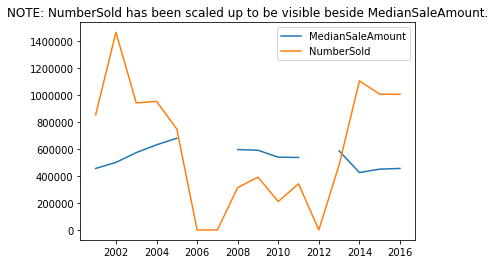

In [109]:
scale_df_row(stamford, 1, 700).transpose().plot(title="NOTE: NumberSold has been scaled up to be visible beside MedianSaleAmount.")

In [110]:
# Let's formalize all of this into a function...

In [118]:
def combine_sales_and_median_sale_amount(town='Connecticut', startyear=MIN_YEAR, endyear=MAX_YEAR, source_df = res_df):
    """
    Returns a dataframe where the first row is the MedianSaleAmount timeseries of town,
    and the second row is the number of homes sold in that town.
    This function feeds ___.
    """
    combined_df = median_timeseries('SaleAmount', town).transpose().append(sale_count_timeseries(town).transpose())
    combined_df.index = ['MedianSaleAmount', 'NumberSold']
    return combined_df

In [119]:
combine_sales_and_median_sale_amount('Stamford')

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
MedianSaleAmount,455000.0,500000.0,572250.0,630000.0,679000.0,NaN,NaN,595000.0,590000.0,538700.0,536500.0,NaN,585000.0,425000.0,450000.0,455250.0
NumberSold,1216.0,2091.0,1344.0,1360.0,1067.0,0.0,0.0,448.0,558.0,300.0,488.0,0.0,689.0,1577.0,1436.0,1434.0


In [120]:
def combined_sales_and_median_sale_amount_timeseries(town='Connecticut', scale_factor=500, startyear=MIN_YEAR,
                                                     endyear=MAX_YEAR, source_df=res_df):
    """
    Returns a timeseries ready to be plotted that graphs the number of sales AND the median sale amount in
    a town, every year from startyear to endyear.
    
    The argument 'scale_factor' is a number to scale the number of sales row by, in order for this line to not appear flat
    beside median sale amount when graphed.
    """
    timeseries = combine_sales_and_median_sale_amount(town, startyear, endyear, source_df)
    timeseries = scale_df_row(timeseries, 1, scale_factor)
    return timeseries.transpose()

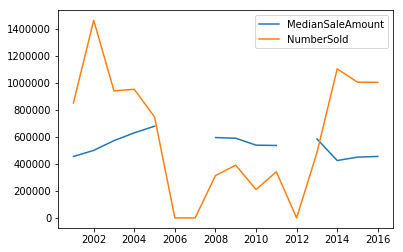

In [121]:
combined_sales_and_median_sale_amount_timeseries('Stamford', 700).plot()

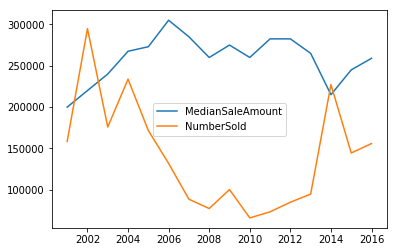

In [137]:
combined_sales_and_median_sale_amount_timeseries('Connecticut', 5).plot()

I don't know if this provides much insight, though.